# **Portfolio Optimization Using Genetic Algorithm**

In [ ]:
Load the data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import pandas as pd

# Load data
df = pd.read_csv('/content/portfolio_data.csv', index_col=0, parse_dates=True)
df.head()


,Asset_1,Asset_2,Asset_3,Portfolio_Value,Market_Index
timestamp,,,,,
01-01-2020,544.883183,423.654799,645.894113,525.051834,1034.932512
02-01-2020,437.587211,891.773001,963.662760,792.579124,1026.081261
03-01-2020,383.441519,791.725038,528.894920,600.939199,1024.844657
06-01-2020,568.044561,925.596638,71.036058,564.754139,966.747919
07-01-2020,87.129300,20.218397,832.619845,290.226071,1036.577579


In [2]:
# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())

# Describe the dataset
print("\nStatistical description of the dataset:")
print(df.describe())


Missing values in the dataset:
Asset_1            0
Asset_2            0
Asset_3            0
Portfolio_Value    0
Market_Index       0
dtype: int64

Statistical description of the dataset:
           Asset_1      Asset_2      Asset_3  Portfolio_Value  Market_Index
count  1043.000000  1043.000000  1043.000000      1043.000000   1043.000000
mean    505.417344   498.410975   507.407638       503.077189    997.548337
std     297.356764   291.427408   286.894731       176.645036     49.233444
min       0.073699     0.367344     0.545965        70.500000    849.675064
25%     247.427971   256.102048   273.493523       364.003843    962.919808
50%     502.453074   498.434786   495.970295       506.941359    997.343083
75%     771.008717   757.283515   754.012006       626.069339   1030.440860
max     998.354877   999.964018   999.808578       953.523039   1190.083011


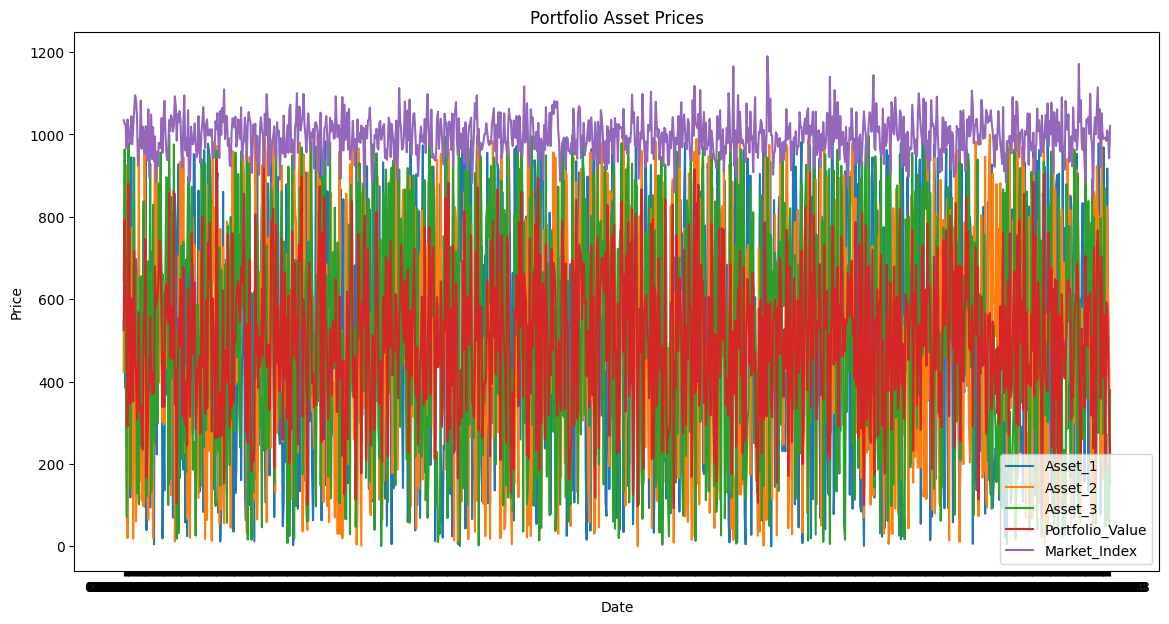

In [5]:
# Plotting the closing prices
plt.figure(figsize=(14, 7))
for column in df.columns:
    plt.plot(df[column], label=column)
plt.title('Portfolio Asset Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [6]:
# Calculate daily returns
returns = df.pct_change().dropna()
print("\nFirst few rows of daily returns:")
print(returns.head())


First few rows of daily returns:
             Asset_1    Asset_2    Asset_3  Portfolio_Value  Market_Index
timestamp                                                                
02-01-2020 -0.196916   1.104952   0.491983         0.509525     -0.008552
03-01-2020 -0.123737  -0.112190  -0.451162        -0.241793     -0.001205
06-01-2020  0.481437   0.169089  -0.865690        -0.060214     -0.056688
07-01-2020 -0.846615  -0.978156  10.721087        -0.486102      0.072232
08-01-2020  7.931057  42.030717   0.175348         2.029164     -0.019868


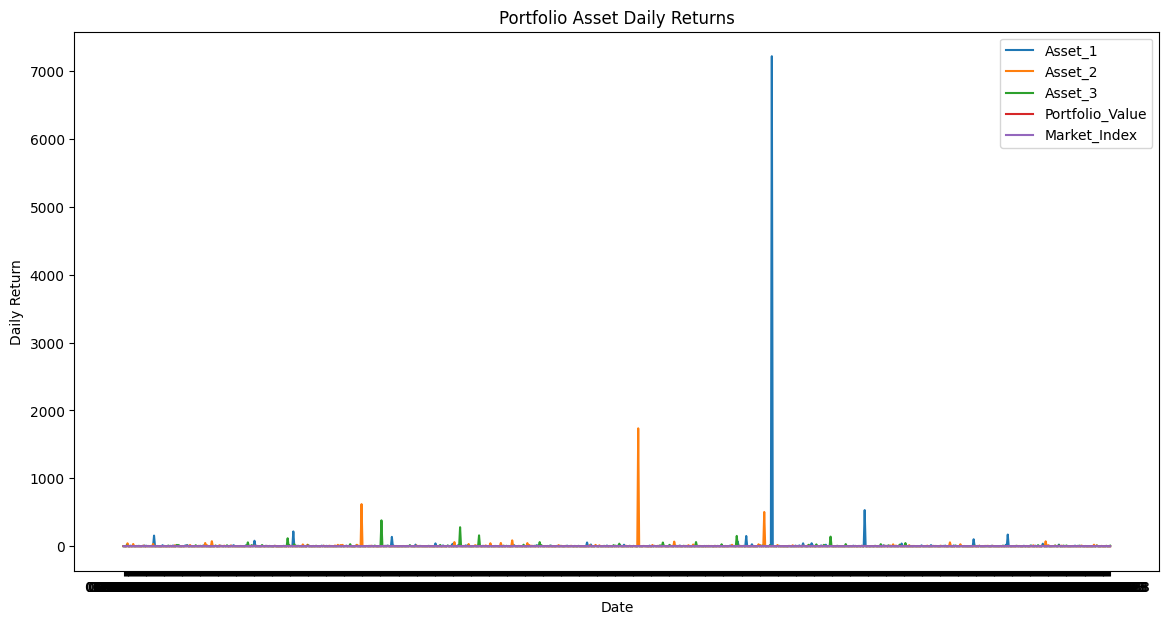

In [7]:
# Plotting daily returns
plt.figure(figsize=(14, 7))
for column in returns.columns:
    plt.plot(returns[column], label=column)
plt.title('Portfolio Asset Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

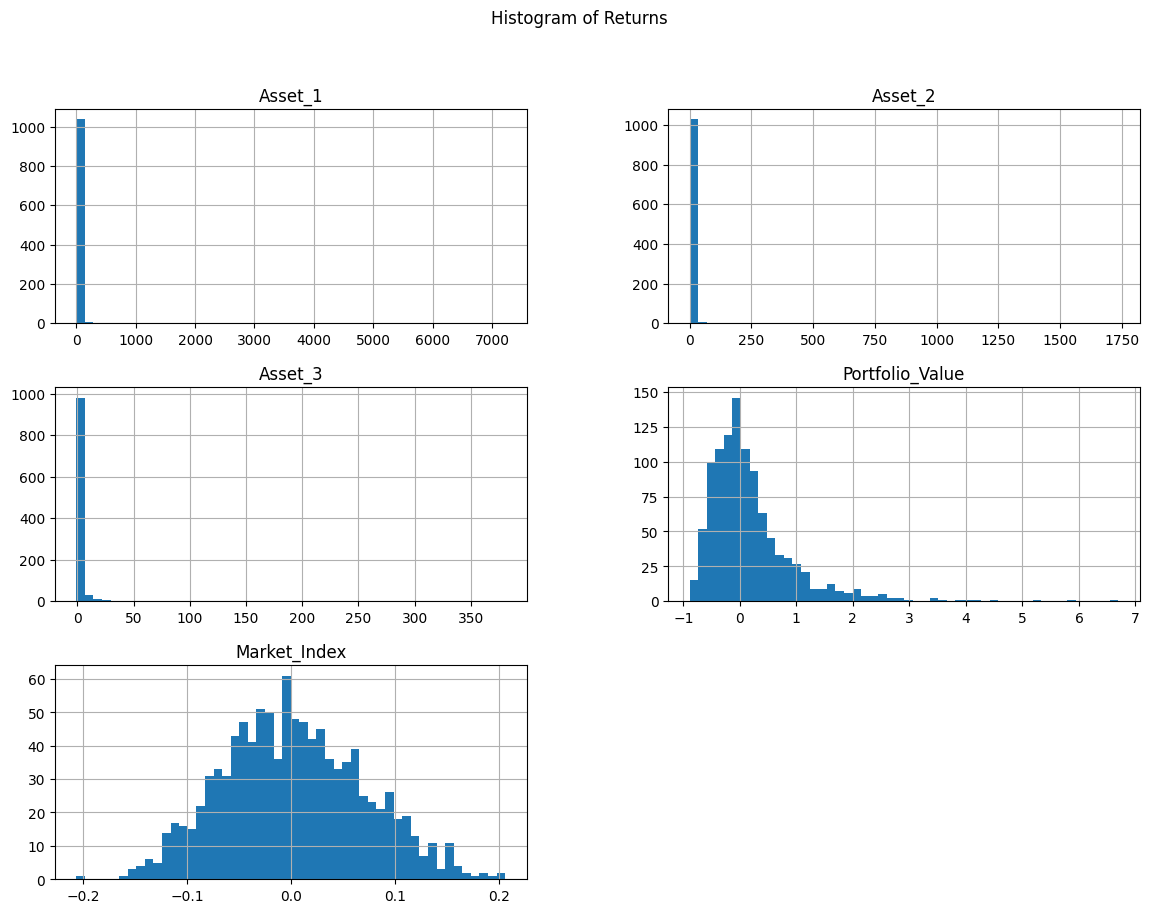

In [9]:
# Plot histogram of returns
returns.hist(bins=50, figsize=(14, 10))
plt.suptitle('Histogram of Returns')
plt.show()

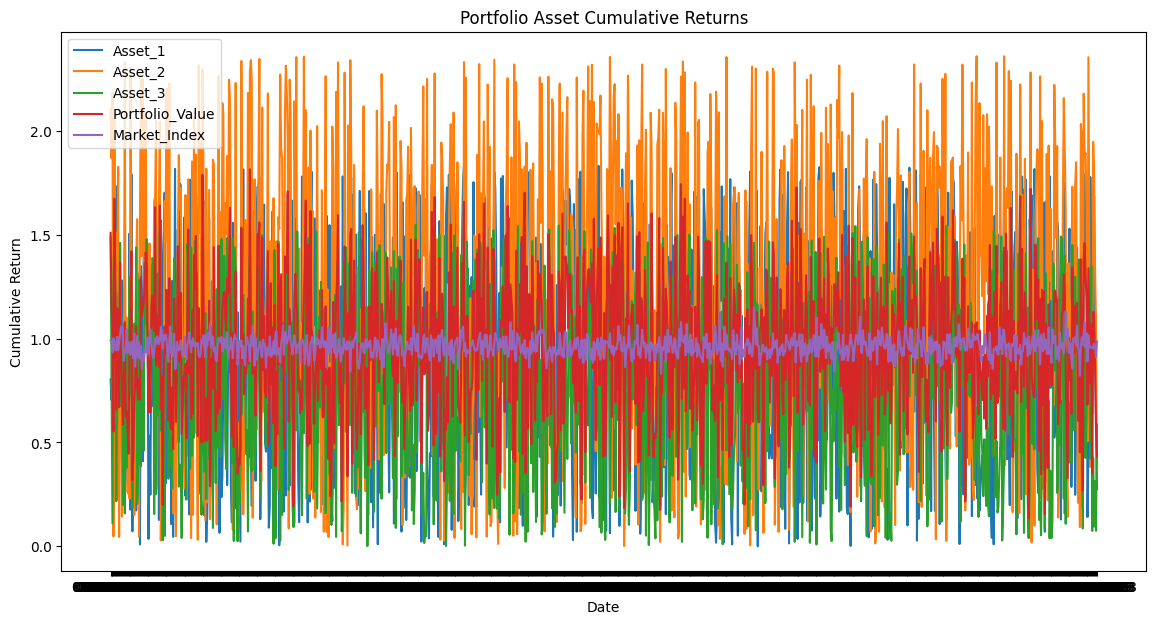

In [10]:
# Calculate cumulative returns
cumulative_returns = (1 + returns).cumprod()
plt.figure(figsize=(14, 7))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns[column], label=column)
plt.title('Portfolio Asset Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

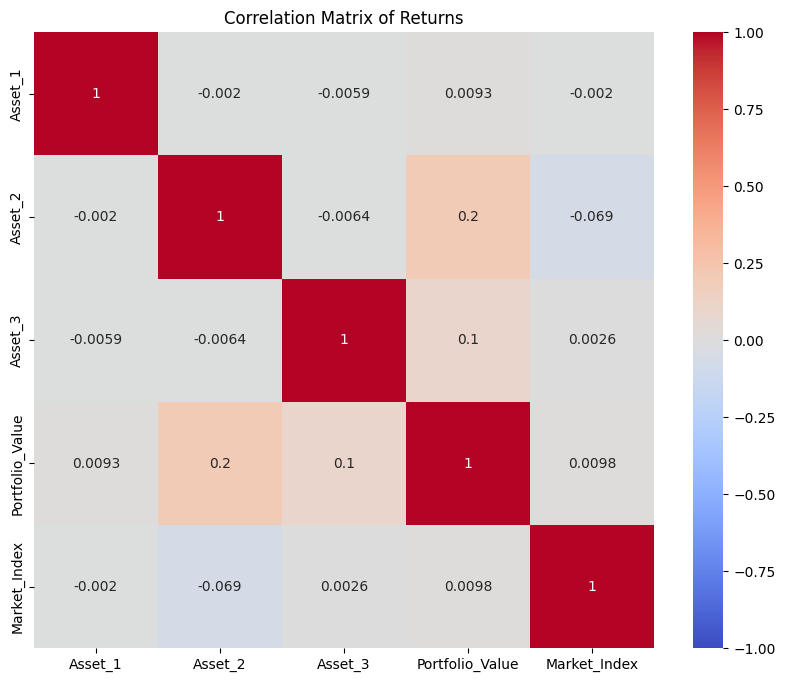

In [8]:
# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Returns')
plt.show()

# **Calculate Return**

In [ ]:
returns = df.pct_change().dropna()
returns.head()


,Asset_1,Asset_2,Asset_3,Portfolio_Value,Market_Index
timestamp,,,,,
02-01-2020,-0.196916,1.104952,0.491983,0.509525,-0.008552
03-01-2020,-0.123737,-0.112190,-0.451162,-0.241793,-0.001205
06-01-2020,0.481437,0.169089,-0.865690,-0.060214,-0.056688
07-01-2020,-0.846615,-0.978156,10.721087,-0.486102,0.072232
08-01-2020,7.931057,42.030717,0.175348,2.029164,-0.019868


# Define Fitness Function

In [ ]:
import numpy as np

def fitness_function(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = portfolio_return / portfolio_stddev
    return sharpe_ratio


# Initial Population

In [ ]:
def initialize_population(pop_size, num_assets):
    population = []
    for _ in range(pop_size):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        population.append(weights)
    return np.array(population)

pop_size = 100
num_assets = len(df.columns)
population = initialize_population(pop_size, num_assets)


# Selection

In [ ]:
def selection(population, fitness_scores, num_parents):
    parents = np.empty((num_parents, population.shape[1]))
    for i in range(num_parents):
        max_fitness_idx = np.where(fitness_scores == np.max(fitness_scores))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[i, :] = population[max_fitness_idx, :]
        fitness_scores[max_fitness_idx] = -999999
    return parents

num_parents = 20
fitness_scores = np.array([fitness_function(weights, returns) for weights in population])
parents = selection(population, fitness_scores, num_parents)


# Crossover

In [ ]:
def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

offspring_size = (pop_size - parents.shape[0], num_assets)
offspring = crossover(parents, offspring_size)


# Mutation

In [ ]:
def mutation(offspring, mutation_rate=0.01):
    for idx in range(offspring.shape[0]):
        for gene_idx in range(offspring.shape[1]):
            if np.random.rand() < mutation_rate:
                random_value = np.random.random()
                offspring[idx, gene_idx] = offspring[idx, gene_idx] + random_value
                offspring[idx, gene_idx] /= np.sum(offspring[idx, :])
    return offspring

mutated_offspring = mutation(offspring)


# Termination

In [ ]:
def mutation(offspring, mutation_rate=0.01):
    for idx in range(offspring.shape[0]):
        for gene_idx in range(offspring.shape[1]):
            if np.random.rand() < mutation_rate:
                random_value = np.random.random()
                offspring[idx, gene_idx] = offspring[idx, gene_idx] + random_value
                offspring[idx, gene_idx] /= np.sum(offspring[idx, :])
    return offspring

mutated_offspring = mutation(offspring)


In [ ]:
def genetic_algorithm(returns, num_generations, pop_size, num_parents, mutation_rate):
    num_assets = returns.shape[1]
    population = initialize_population(pop_size, num_assets)
    for generation in range(num_generations):
        fitness_scores = np.array([fitness_function(weights, returns) for weights in population])
        parents = selection(population, fitness_scores, num_parents)
        offspring_size = (pop_size - parents.shape[0], num_assets)
        offspring = crossover(parents, offspring_size)
        offspring = mutation(offspring, mutation_rate)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = offspring
        best_fitness = np.max(fitness_scores)
        print(f"Generation {generation}: Best Fitness = {best_fitness}")
    return population, fitness_scores

num_generations = 100
population, fitness_scores = genetic_algorithm(returns, num_generations, pop_size, num_parents, mutation_rate=0.01)


Generation 0: Best Fitness = 1.417253614680323
Generation 1: Best Fitness = 1.8779466185434148
Generation 2: Best Fitness = 2.0430037580572336
Generation 3: Best Fitness = 2.0920158355234864
Generation 4: Best Fitness = 2.4902477236462275
Generation 5: Best Fitness = 2.4902477236462275
Generation 6: Best Fitness = 2.4902477236462275
Generation 7: Best Fitness = 2.521225040481554
Generation 8: Best Fitness = 2.521225040481554
Generation 9: Best Fitness = 2.5409096684344568
Generation 10: Best Fitness = 2.5409096684344568
Generation 11: Best Fitness = 2.5414701981903742
Generation 12: Best Fitness = 2.5414701981903742
Generation 13: Best Fitness = 2.575155889229864
Generation 14: Best Fitness = 2.575155889229864
Generation 15: Best Fitness = 2.575155889229864
Generation 16: Best Fitness = 2.5758970013396527
Generation 17: Best Fitness = 2.5758970013396527
Generation 18: Best Fitness = 2.5759063088633067
Generation 19: Best Fitness = 2.5760569272179454
Generation 20: Best Fitness = 2.5760

# Evaluate Best portfolio

In [ ]:
best_idx = np.argmax(fitness_scores)
best_portfolio = population[best_idx, :]
best_portfolio_return = np.sum(returns.mean() * best_portfolio) * 252
best_portfolio_stddev = np.sqrt(np.dot(best_portfolio.T, np.dot(returns.cov() * 252, best_portfolio)))
best_portfolio_sharpe = best_portfolio_return / best_portfolio_stddev

print(f"Best Portfolio Weights: {best_portfolio}")
print(f"Expected Annual Return: {best_portfolio_return}")
print(f"Annual Volatility: {best_portfolio_stddev}")
print(f"Sharpe Ratio: {best_portfolio_sharpe}")


Best Portfolio Weights: [0.04189262 0.13620183 0.72651027 0.56140873 0.49904594]
Expected Annual Return: 737.635018426684
Annual Volatility: 284.1045836421465
Sharpe Ratio: 2.5963502910456278
